In [133]:
# Import required libraries
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc


In [134]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')


### Feature Selection

In [135]:
#drop non-protein coding genes

# Step 1: Filter for protein coding genes (from your original code)
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
rnaseq_df_filtered = rnaseq_df[final_columns]


In [136]:

# Step 2: Calculate mean expression for each gene
# First, separate metadata columns from gene expression columns
gene_expression = rnaseq_df_filtered[protein_coding_cols]
metadata = rnaseq_df_filtered[columns_to_keep]


In [137]:

# Calculate mean expression for each gene
gene_means = gene_expression.mean(axis=0)

# Calculate number of genes to keep (top 2%)
n_genes_to_keep = 400

# Get the column names (genes) with highest mean expression
top_genes = gene_means.nlargest(n_genes_to_keep).index

# Create final dataframe with metadata and top genes
final_df = pd.concat([metadata, rnaseq_df_filtered[top_genes]], axis=1)


In [138]:

# Print information about the filtering
print("Original number of protein coding genes:", len(protein_coding_cols))
print("Number of top genes kept (2%):", n_genes_to_keep)
print("\nDataframe shapes:")
print("Original:", rnaseq_df.shape)
print("After protein coding filter:", rnaseq_df_filtered.shape)
print("Final (with top 2% genes):", final_df.shape)


Original number of protein coding genes: 19962
Number of top genes kept (2%): 400

Dataframe shapes:
Original: (1231, 60663)
After protein coding filter: (1231, 19965)
Final (with top 2% genes): (1231, 403)


In [139]:

# Optional: Show summary statistics of the mean expression values
print("\nMean expression summary for top genes:")
print(gene_means[top_genes].describe())

# Save results to new dataframe
rnaseq_df_top_genes = final_df

# Optional: verify that our key columns are still present
print("\nChecking if key columns are present:")
for col in columns_to_keep:
    print(f"{col} present: {col in rnaseq_df_top_genes.columns}")


Mean expression summary for top genes:
count     400.000000
mean      339.773484
std       799.847929
min        80.347665
25%       103.432431
50%       135.239130
75%       242.387309
max      7294.766159
dtype: float64

Checking if key columns are present:
Case ID present: True
Sample ID present: True
Sample Type present: True


In [140]:
# Drop rows where event.BRCA1 is '1'
brca_df_filtered = brca_df[brca_df['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
brca_df_filtered = brca_df_filtered[brca_df_filtered['event.PALB2'] != '2']

In [141]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df_top_genes['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df_filtered.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))



Number of common samples: 857


In [142]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df_top_genes[rnaseq_df_top_genes['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (921, 403)
hrd_df_common: (857, 5)
brca_df_common: (857, 33)


In [143]:
# Step 1: Merge rnaseq_df_common and hrd_df_common
merged_df = pd.merge(rnaseq_df_common, hrd_df_common, 
                     left_on='Case ID', right_on='sample', 
                     how='right')

# Step 2: Merge the result with brca_df_common
final_merged_df = pd.merge(merged_df, brca_df_common, 
                           left_on='Case ID', right_index=True, 
                           how='right')

# Print the shape of the final merged dataframe
print("Final merged dataframe shape:", final_merged_df.shape)


# # List of columns in the final merged dataframe
# print("\nColumns in the merged dataframe:")
# print(final_merged_df.columns.tolist())

# Check for any duplicate columns that might have been created during the merge
duplicate_columns = final_merged_df.columns[final_merged_df.columns.duplicated()].tolist()
if duplicate_columns:
    print("\nWarning: The following columns are duplicated:")
    print(duplicate_columns)
else:
    print("\nNo duplicate columns found.")

# Save the merged dataframe to a CSV file (optional)
# final_merged_df.to_csv('merged_dataframe.csv', index=False)

Final merged dataframe shape: (921, 441)

No duplicate columns found.


In [144]:
final_merged_df = final_merged_df.set_index('Case ID')
final_merged_df.head()

,Sample ID,Sample Type,ENSG00000198938.2|MT-CO3|protein_coding,ENSG00000198712.1|MT-CO2|protein_coding,ENSG00000198804.2|MT-CO1|protein_coding,ENSG00000198886.2|MT-ND4|protein_coding,ENSG00000198899.2|MT-ATP6|protein_coding,ENSG00000198727.2|MT-CYB|protein_coding,ENSG00000198840.2|MT-ND3|protein_coding,ENSG00000198888.2|MT-ND1|protein_coding,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A1XK,TCGA-D8-A1XK-01A,Primary Tumor,1715.6532,2195.9776,1069.8340,1895.6838,1130.0276,1038.8825,1417.9303,593.3981,...,0.232403,0.000000,0.005672,Bi-allelic-inactivation,0,0,0,YES,Basal,TNBC
TCGA-A1-A0SO,TCGA-A1-A0SO-01A,Primary Tumor,6302.2194,9176.6149,6096.7537,9248.8499,6426.0177,4546.8457,5304.7236,2361.7618,...,0.741487,0.201367,0.053392,0,0,0,0,0,Basal,TNBC
TCGA-D8-A1XQ,TCGA-D8-A1XQ-01A,Primary Tumor,1071.3228,1854.9848,1795.3348,1458.2107,792.2934,792.4994,945.1728,811.3210,...,0.228409,0.165768,0.033062,Bi-allelic-inactivation,0,0,0,YES,Basal,TNBC
TCGA-BH-A0BZ,TCGA-BH-A0BZ-01A,Primary Tumor,3305.0621,4492.4593,4130.3901,3541.6133,1658.0747,1677.0072,1584.7226,1792.5200,...,0.703508,0.106716,0.127285,0,Bi-allelic-inactivation,0,0,YES,LumB,0
TCGA-BH-A0BZ,TCGA-BH-A0BZ-11A,Solid Tissue Normal,9614.9775,7493.5606,9860.5648,10830.1196,5753.7072,7522.9914,5091.3998,8154.3637,...,0.703508,0.106716,0.127285,0,Bi-allelic-inactivation,0,0,YES,LumB,0


In [145]:
na_count = final_merged_df['event.All Events'].isna().sum()
print(na_count)
final_merged_df.shape

final_merged_df['HRD_status'] = [1 if x >= 42 else 0 for x in final_merged_df['HRD-sum']]
final_merged_df['HRD_status'].value_counts()


0


HRD_status
0    699
1    222
Name: count, dtype: int64

In [146]:

#save final merged dataframe
final_merged_df.to_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index=True)

In [147]:

#save final merged dataframe
final_merged_df.to_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.txt', index=True)

In [148]:
final_merged_df["HRD_status"].value_counts()

HRD_status
0    699
1    222
Name: count, dtype: int64

In [182]:
final_merged_df['event.PAM50'].value_counts()

event.PAM50
LumA     458
LumB     212
Basal    153
Her2      82
nan       16
Name: count, dtype: int64

In [166]:
final_merged_df['event.PAM50'].astype(str).value_counts()

event.PAM50
LumA     458
LumB     212
Basal    153
Her2      82
nan       16
Name: count, dtype: int64

### Stratified Selection/Downsampling

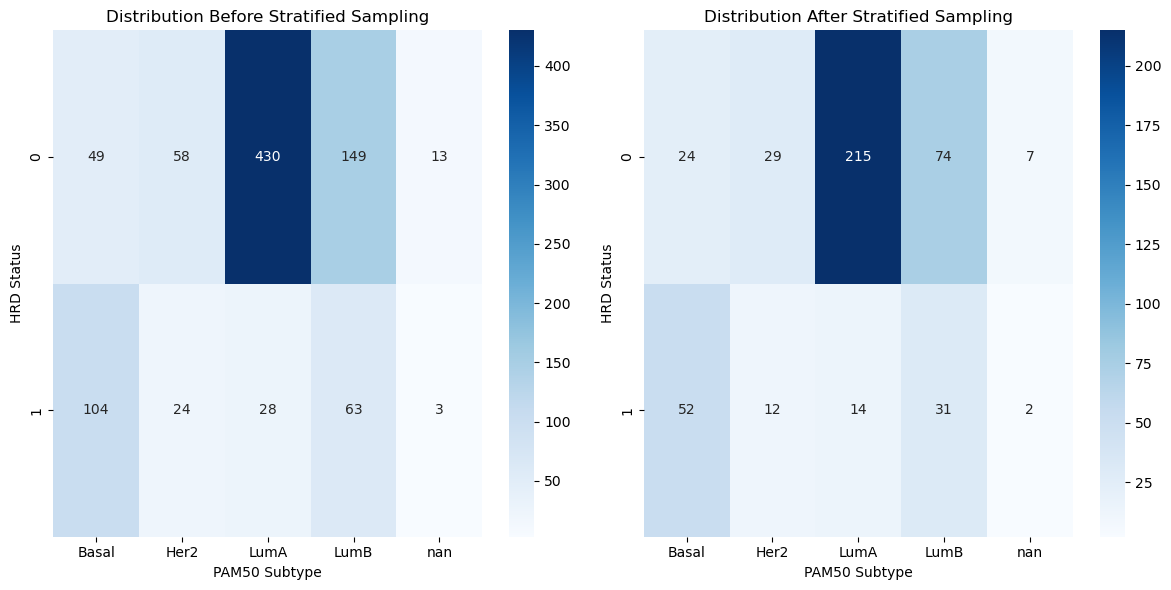

(event.PAM50  Basal  Her2  LumA  LumB  nan
 HRD_status                               
 0               49    58   430   149   13
 1              104    24    28    63    3,
 event.PAM50  Basal  Her2  LumA  LumB  nan
 HRD_status                               
 0               24    29   215    74    7
 1               52    12    14    31    2,
 (247.084060412412, 2.7649923837106922e-52))

In [183]:
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

final_merged_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index_col=0)

# Define HRD status and PAM50 subtype for stratification
final_merged_df['HRD_status'] = final_merged_df['HRD_status'].astype(str)
final_merged_df['event.PAM50'] = final_merged_df['event.PAM50'].astype(str)
hrd_col = 'HRD_status'
pam50_col = 'event.PAM50'

# Count the distribution of HRD status and PAM50 subtypes
distribution_before = final_merged_df.groupby([hrd_col, pam50_col]).size().unstack(fill_value=0)

# Perform stratified sampling
stratified_data, _, _, _ = train_test_split(
    final_merged_df, 
    final_merged_df[[hrd_col, pam50_col]], 
    stratify=final_merged_df[[hrd_col, pam50_col]], 
    test_size=0.5, 
    random_state=42
)

# Count the distribution after stratified sampling
distribution_after = stratified_data.groupby([hrd_col, pam50_col]).size().unstack(fill_value=0)

# Chi-square test for independence
chi2, p, _, _ = chi2_contingency(distribution_before)

# Visualization of distribution before and after
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(distribution_before, annot=True, fmt="d", cmap='Blues')
plt.title('Distribution Before Stratified Sampling')
plt.xlabel('PAM50 Subtype')
plt.ylabel('HRD Status')

plt.subplot(1, 2, 2)
sns.heatmap(distribution_after, annot=True, fmt="d", cmap='Blues')
plt.title('Distribution After Stratified Sampling')
plt.xlabel('PAM50 Subtype')
plt.ylabel('HRD Status')

plt.tight_layout()
plt.show()

distribution_before, distribution_after, (chi2, p)


In [180]:
# Check for missing values in the relevant columns
missing_values = final_merged_df[[hrd_col, pam50_col]].isnull().sum()
missing_values
final_merged_df[[hrd_col, pam50_col]].isnull()


,HRD_status,event.PAM50
Case ID,,
TCGA-D8-A1XK,False,False
TCGA-A1-A0SO,False,False
TCGA-D8-A1XQ,False,False
TCGA-BH-A0BZ,False,False
TCGA-BH-A0BZ,False,False
...,...,...
TCGA-EW-A1IZ,False,False
TCGA-GM-A3XN,False,False
TCGA-PE-A5DE,False,False


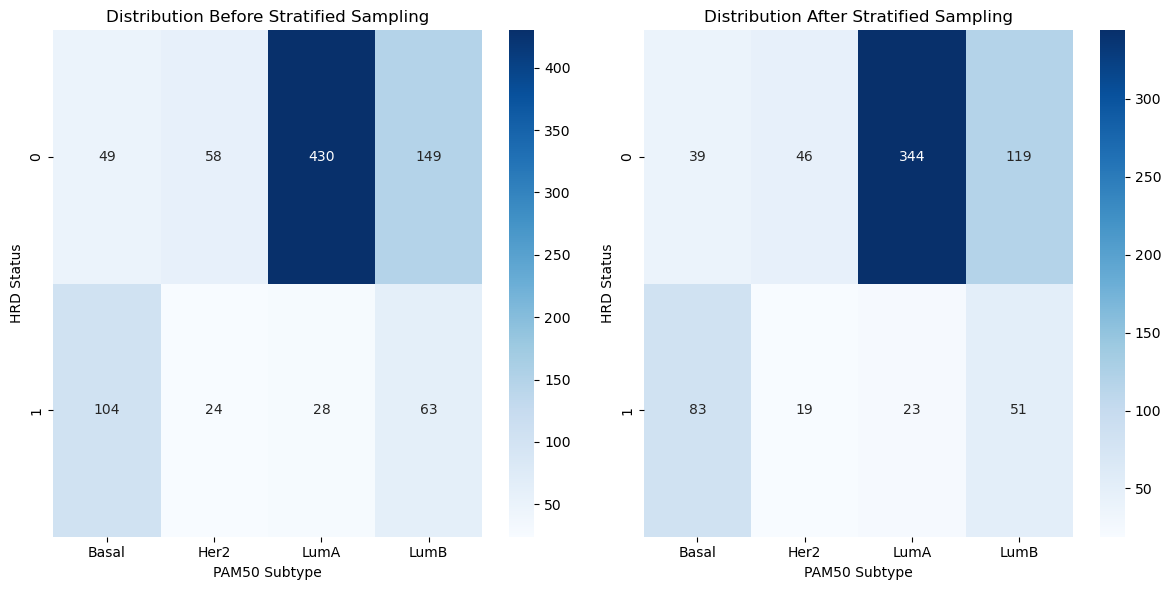

(event.PAM50  Basal  Her2  LumA  LumB
 HRD_status                          
 0               49    58   430   149
 1              104    24    28    63,
 event.PAM50  Basal  Her2  LumA  LumB
 HRD_status                          
 0               39    46   344   119
 1               83    19    23    51,
 (246.17039570461333, 4.406454792083444e-53))

In [193]:
final_merged_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index_col=0)

# Drop rows with missing PAM50 subtype values
cleaned_data = final_merged_df.dropna(subset=[pam50_col])

# Check the distribution of HRD status and PAM50 subtypes after cleaning
distribution_cleaned = cleaned_data.groupby([hrd_col, pam50_col]).size().unstack(fill_value=0)

# Perform stratified sampling again
stratified_data, _, _, _ = train_test_split(
    cleaned_data, 
    cleaned_data[[hrd_col, pam50_col]], 
    stratify=cleaned_data[[hrd_col, pam50_col]], 
    test_size=float(0.2), 
    random_state=42
)

# Count the distribution after stratified sampling
distribution_after = stratified_data.groupby([hrd_col, pam50_col]).size().unstack(fill_value=0)

# Chi-square test for independence
chi2, p, _, _ = chi2_contingency(distribution_cleaned)

# Visualization of distribution before and after
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(distribution_cleaned, annot=True, fmt="d", cmap='Blues')
plt.title('Distribution Before Stratified Sampling')
plt.xlabel('PAM50 Subtype')
plt.ylabel('HRD Status')

plt.subplot(1, 2, 2)
sns.heatmap(distribution_after, annot=True, fmt="d", cmap='Blues')
plt.title('Distribution After Stratified Sampling')
plt.xlabel('PAM50 Subtype')
plt.ylabel('HRD Status')

plt.tight_layout()
plt.show()

distribution_cleaned, distribution_after, (chi2, p)


In [192]:

print('''The Chi-square statistic is approx 246.17, with p-value of approximately 4.41e-53. 
    Strong association between HRD status & PAM50 subtype, suggesting that they're not independent.
''')


The Chi-square statistic is approx 246.17, with p-value of approximately 4.41e-53. 
    Strong association between HRD status & PAM50 subtype, suggesting that they're not independent.



In [220]:
# List to store the balanced data
balanced_data = []

# For each PAM50 subtype, balance the number of HRD and non-HRD samples
for pam50_subtype, group in final_merged_df.groupby(pam50_col):
    hrd_group = group[group[hrd_col] == '1']  # HRD-positive samples
    non_hrd_group = group[group[hrd_col] == '0']  # HRD-negative samples
    
    # Check if both HRD and non-HRD groups are non-empty
    if len(hrd_group) > 0 and len(non_hrd_group) > 0:
        # Find the smaller group size
        min_size = min(len(hrd_group), len(non_hrd_group))
        
        # Resample both HRD-positive and HRD-negative groups to match the smaller group size
        hrd_balanced = resample(hrd_group, replace=False, n_samples=min_size, random_state=42)
        non_hrd_balanced = resample(non_hrd_group, replace=False, n_samples=min_size, random_state=42)
        
        # Combine the balanced groups for this PAM50 subtype
        balanced_group = pd.concat([hrd_balanced, non_hrd_balanced])
        
        # Add to the list of balanced data
        balanced_data.append(balanced_group)

# Ensure there's at least one group to concatenate
if len(balanced_data) > 0:
    # Combine all balanced PAM50 subtype groups
    balanced_data_df = pd.concat(balanced_data)

    # Count the distribution after balanced sampling
    distribution_balanced = balanced_data_df.groupby([hrd_col, pam50_col]).size().unstack(fill_value=0)

    # Chi-square test for independence after balancing
    chi2_balanced, p_balanced, _, _ = chi2_contingency(distribution_balanced)

    # Visualization of distribution after balanced sampling
    plt.figure(figsize=(6, 6))
    sns.heatmap(distribution_balanced, annot=True, fmt="d", cmap='Blues')
    plt.title('Distribution After Balanced Sampling')
    plt.xlabel('PAM50 Subtype')
    plt.ylabel('HRD Status')

    plt.tight_layout()
    plt.show()

    # Display the distributions and chi-square test results
    distribution_before, distribution_after, distribution_balanced, (chi2_balanced, p_balanced)
else:
    print("No valid groups to balance after resampling.")


No valid groups to balance after resampling.


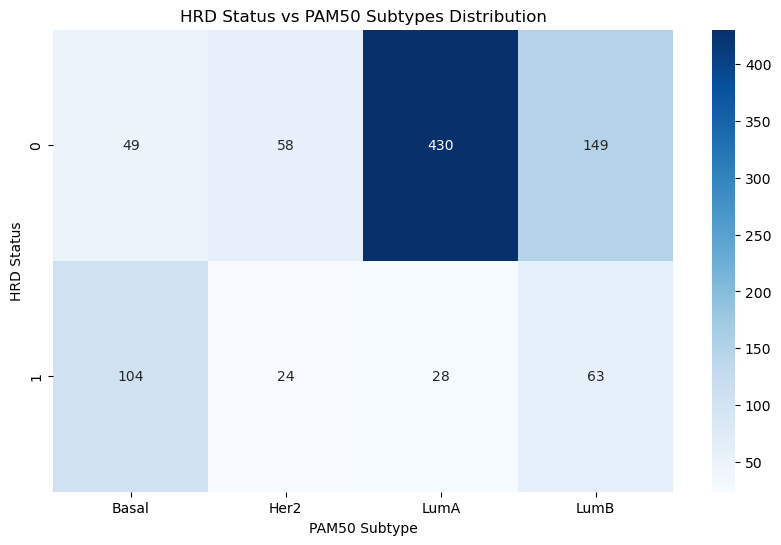

event.PAM50  Basal  Her2  LumA  LumB
HRD_status                          
0               49    58   430   149
1              104    24    28    63


In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

final_merged_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index_col=0)

# Drop rows with missing PAM50 subtype values
cleaned = final_merged_df.dropna(subset=[pam50_col])



# Check the distribution of HRD status and PAM50 subtypes
distribution_check_new = cleaned.groupby(['HRD_status', 'event.PAM50']).size().unstack(fill_value=0)

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.heatmap(distribution_check_new, annot=True, cmap='Blues', fmt='d')
plt.title('HRD Status vs PAM50 Subtypes Distribution')
plt.xlabel('PAM50 Subtype')
plt.ylabel('HRD Status')
plt.show()

# Print distribution for further analysis
print(distribution_check_new)


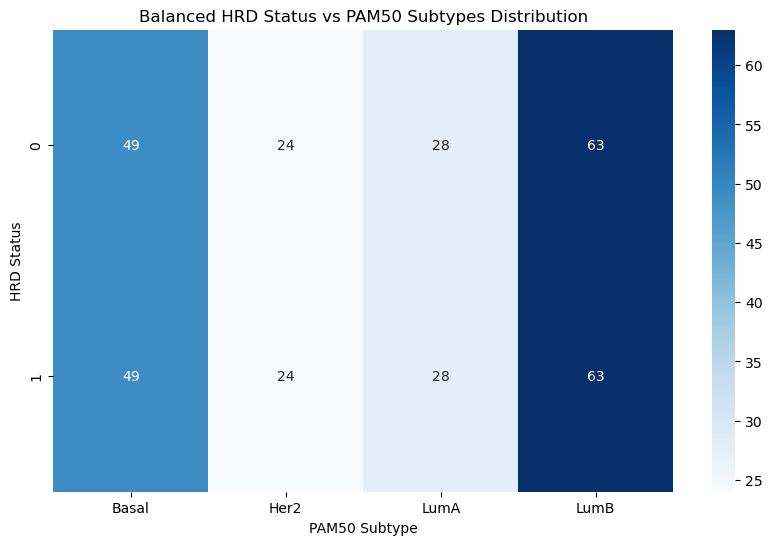

event.PAM50  Basal  Her2  LumA  LumB
HRD_status                          
0               49    24    28    63
1               49    24    28    63


In [235]:

from sklearn.utils import resample

# Group by PAM50 subtypes and HRD status
groups = cleaned.groupby('event.PAM50')

# List to store the balanced data
balanced_data = []

# Iterate through each PAM50 subtype
for pam50_subtype, group in groups:
    # Separate the group into HRD-positive (HRD=1) and HRD-negative (HRD=0)
    hrd_positive = group[group['HRD_status'] == 1]
    hrd_negative = group[group['HRD_status'] == 0]
    
    # Find the smaller size between HRD-positive and HRD-negative
    min_size = min(len(hrd_positive), len(hrd_negative))
    
    # If both groups have samples, perform resampling
    if min_size > 0:
        # Resample both HRD-positive and HRD-negative to the smaller size
        hrd_positive_resampled = resample(hrd_positive, replace=False, n_samples=min_size, random_state=42)
        hrd_negative_resampled = resample(hrd_negative, replace=False, n_samples=min_size, random_state=42)
        
        # Combine resampled groups
        balanced_subtype_group = pd.concat([hrd_positive_resampled, hrd_negative_resampled])
        
        # Add to the list of balanced data
        balanced_data.append(balanced_subtype_group)

# Combine all balanced PAM50 subtype groups into a single DataFrame
balanced_data_df = pd.concat(balanced_data)

# Check the new distribution of HRD status and PAM50 subtypes
balanced_distribution = balanced_data_df.groupby(['HRD_status', 'event.PAM50']).size().unstack(fill_value=0)

# Visualize the balanced distribution
plt.figure(figsize=(10, 6))
sns.heatmap(balanced_distribution, annot=True, cmap='Blues', fmt='d')
plt.title('Balanced HRD Status vs PAM50 Subtypes Distribution')
plt.xlabel('PAM50 Subtype')
plt.ylabel('HRD Status')
plt.show()

# Print the new balanced distribution
print(balanced_distribution)


## Downsampling

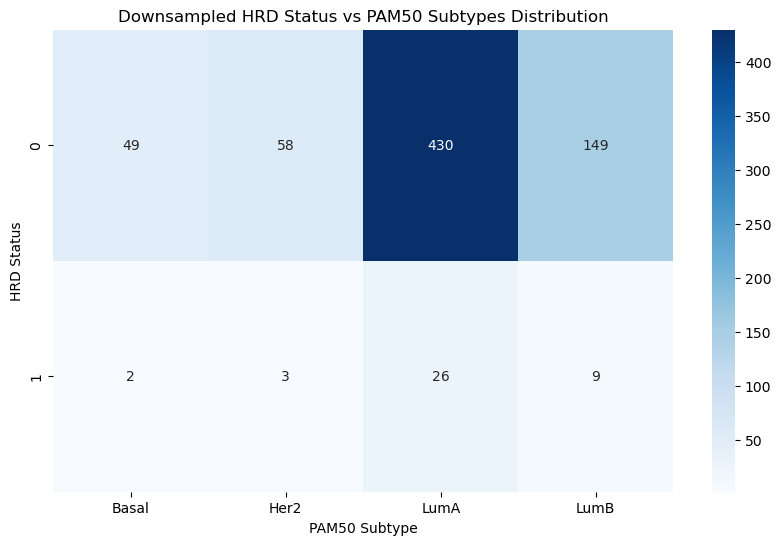

event.PAM50  Basal  Her2  LumA  LumB
HRD_status                          
0               49    58   430   149
1                2     3    26     9


In [237]:
from sklearn.utils import resample

final_merged_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index_col=0)

# Drop rows with missing PAM50 subtype values
cleaned = final_merged_df.dropna(subset=[pam50_col])

# Calculate the smallest proportion of HRD1/HRD0 across all PAM50 subtypes
proportion_df = cleaned.groupby(['event.PAM50', 'HRD_status']).size().unstack(fill_value=0)
proportion_df['proportion'] = proportion_df[1] / (proportion_df[0] + proportion_df[1])

# Find the smallest HRD1/HRD0 proportion
min_proportion = proportion_df['proportion'].min()

# List to store the downsampled data
downsampled_data = []

# Iterate through each PAM50 subtype
for pam50_subtype, group in cleaned.groupby('event.PAM50'):
    hrd_positive = group[group['HRD_status'] == 1]
    hrd_negative = group[group['HRD_status'] == 0]
    
    # Calculate the number of HRD-positive samples to match the desired proportion
    target_hrd_positive_size = int(len(hrd_negative) * min_proportion)
    
    # If HRD-positive samples exceed the target size, downsample them
    if len(hrd_positive) > target_hrd_positive_size:
        hrd_positive_resampled = resample(hrd_positive, replace=False, n_samples=target_hrd_positive_size, random_state=42)
    else:
        hrd_positive_resampled = hrd_positive
    
    # Combine HRD-negative and resampled HRD-positive
    downsampled_group = pd.concat([hrd_positive_resampled, hrd_negative])
    
    # Add to the list of downsampled data
    downsampled_data.append(downsampled_group)

# Combine all downsampled PAM50 subtype groups
downsampled_data_df = pd.concat(downsampled_data)

# Check the new distribution of HRD status and PAM50 subtypes
downsampled_distribution = downsampled_data_df.groupby(['HRD_status', 'event.PAM50']).size().unstack(fill_value=0)

# Visualize the downsampled distribution
plt.figure(figsize=(10, 6))
sns.heatmap(downsampled_distribution, annot=True, cmap='Blues', fmt='d')
plt.title('Downsampled HRD Status vs PAM50 Subtypes Distribution')
plt.xlabel('PAM50 Subtype')
plt.ylabel('HRD Status')
plt.show()

# Print the new downsampled distribution
print(downsampled_distribution)


## Models

In [213]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Load the dataset again
# final_merged_df = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index_col=0)

data = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t')

# Drop rows with missing PAM50 subtype values
cleaned_data = data.dropna(subset=['event.PAM50'])

# Perform stratified sampling
stratified_data, _, _, _ = train_test_split(
    cleaned_data, 
    cleaned_data[['HRD_status', 'event.PAM50']], 
    stratify=cleaned_data[['HRD_status', 'event.PAM50']], 
    test_size=0.5, 
    random_state=42
)

# Separate the classes for downsampling
hrd_0 = stratified_data[stratified_data['HRD_status'] == 0]
hrd_1 = stratified_data[stratified_data['HRD_status'] == 1]

# Downsample the TNBC samples (HRD 0) to match the number of HRD 1 samples
hrd_0_downsampled = resample(
    hrd_0, 
    replace=False,  # without replacement
    n_samples=len(hrd_1),  # match the number of HRD 1 samples
    random_state=42  # reproducible results
)

# Combine the downsampled HRD 0 with HRD 1
balanced_data = pd.concat([hrd_0_downsampled, hrd_1])

# Prepare the features (X) and target variable (y)
X_numeric = balanced_data.select_dtypes(include=['float64', 'int64'])
y = balanced_data['HRD_status']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train Elastic Net model
elastic_net = ElasticNetCV(cv=5, random_state=42)
elastic_net.fit(X_scaled, y)

# Predict using Elastic Net
y_pred_en = elastic_net.predict(X_scaled)
y_pred_en_binary = (y_pred_en > 0.5).astype(int)

# Train XGBoost model
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_scaled, y)

# Predict using XGBoost
y_pred_xgb = xgboost_model.predict(X_scaled)

# Calculate accuracy for both models
accuracy_en = accuracy_score(y, y_pred_en_binary)
accuracy_xgb = accuracy_score(y, y_pred_xgb)

# Generate confusion matrices
confusion_en = confusion_matrix(y, y_pred_en_binary)
confusion_xgb = confusion_matrix(y, y_pred_xgb)

# Compile results
results = {
    'Elastic Net Accuracy': accuracy_en,
    'XGBoost Accuracy': accuracy_xgb,
    'Elastic Net Confusion Matrix': confusion_en,
    'XGBoost Confusion Matrix': confusion_xgb,
    'Classification Report (Elastic Net)': classification_report(y, y_pred_en_binary),
    'Classification Report (XGBoost)': classification_report(y, y_pred_xgb)
}

results


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:26:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'Elastic Net Accuracy': 1.0,
 'XGBoost Accuracy': 1.0,
 'Elastic Net Confusion Matrix': array([[109,   0],
        [  0, 109]]),
 'XGBoost Confusion Matrix': array([[109,   0],
        [  0, 109]]),
 'Classification Report (Elastic Net)': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       109\n           1       1.00      1.00      1.00       109\n\n    accuracy                           1.00       218\n   macro avg       1.00      1.00      1.00       218\nweighted avg       1.00      1.00      1.00       218\n',
 'Classification Report (XGBoost)': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       109\n           1       1.00      1.00      1.00       109\n\n    accuracy                           1.00       218\n   macro avg       1.00      1.00      1.00       218\nweighted avg       1.00      1.00      1.00       218\n'}

In [216]:
def permutation_importance_adjusted(model, X, y, n_repeats=30, is_regression=False):
    """Calculate permutation importance for a model, adjusting for regression or classification."""
    if is_regression:
        baseline_score = accuracy_score(y, (model.predict(X) > 0.5).astype(int))
    else:
        baseline_score = accuracy_score(y, model.predict(X))

    importances = np.zeros(X.shape[1])
    
    for i in range(n_repeats):
        for col in range(X.shape[1]):
            X_permuted = X.copy()
            X_permuted[:, col] = np.random.permutation(X[:, col])
            score = accuracy_score(y, model.predict(X_permuted) > 0.5) if is_regression else accuracy_score(y, model.predict(X_permuted))
            importances[col] += baseline_score - score

    return importances / n_repeats

# Calculate permutation importance for both models
elastic_net_importance = permutation_importance_adjusted(elastic_net, X_scaled, y, is_regression=True)
xgboost_importance = permutation_importance_adjusted(xgboost_model, X_scaled, y, is_regression=False)

# Display the importance results
importance_results = {
    'Elastic Net Permutation Importance': elastic_net_importance,
    'XGBoost Permutation Importance': xgboost_importance
}

importance_results


{'Elastic Net Permutation Importance': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.

In [219]:
# Initialize a dictionary to store results
performance_results_final = {}

# Iterate through unique PAM50 subtypes
for pam50_subtype in balanced_data['event.PAM50'].cat.categories:
    # Filter data for the specific PAM50 subtype
    subtype_data = balanced_data[balanced_data['event.PAM50'] == pam50_subtype]

    # Prepare features and target variable for this subtype
    # Only include numeric features
    X_subtype = subtype_data[original_feature_columns].drop(columns=['HRD_status'])
    y_subtype = subtype_data['HRD_status']

    # Ensure we're not including non-numeric features
    X_subtype = X_subtype.select_dtypes(include=['float64', 'int64'])

    # Standardize features for the subtype
    X_subtype_scaled = scaler.transform(X_subtype)

    # Predict using both models
    y_pred_en_subtype = elastic_net_final.predict(X_subtype_scaled) > 0.5
    y_pred_xgb_subtype = xgboost_final_fast.predict(X_subtype_scaled)

    # Calculate accuracy for both models
    accuracy_en_subtype = accuracy_score(y_subtype, y_pred_en_subtype)
    accuracy_xgb_subtype = accuracy_score(y_subtype, y_pred_xgb_subtype)

    # Generate confusion matrices
    confusion_en_subtype = confusion_matrix(y_subtype, y_pred_en_subtype)
    confusion_xgb_subtype = confusion_matrix(y_subtype, y_pred_xgb_subtype)

    # Store results
    performance_results_final[pam50_subtype] = {
        'Elastic Net Accuracy': accuracy_en_subtype,
        'XGBoost Accuracy': accuracy_xgb_subtype,
        'Elastic Net Confusion Matrix': confusion_en_subtype,
        'XGBoost Confusion Matrix': confusion_xgb_subtype
    }

performance_results_final


NameError: name 'original_feature_columns' is not defined

## other feature selection methods

In [242]:
import pandas as pd

# Load your dataset
data = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index_col=0)

# Drop rows with missing PAM50 subtype values
data = data.dropna(subset=[pam50_col])
# Identify categorical columns (typically non-numeric)
categorical_cols = data.select_dtypes(include=['object']).columns


# Apply one-hot encoding to all categorical columns, using drop_first to avoid multicollinearity
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Show the first few rows of the encoded dataset
data_encoded.head()


,ENSG00000198938.2|MT-CO3|protein_coding,ENSG00000198712.1|MT-CO2|protein_coding,ENSG00000198804.2|MT-CO1|protein_coding,ENSG00000198886.2|MT-ND4|protein_coding,ENSG00000198899.2|MT-ATP6|protein_coding,ENSG00000198727.2|MT-CYB|protein_coding,ENSG00000198840.2|MT-ND3|protein_coding,ENSG00000198888.2|MT-ND1|protein_coding,ENSG00000198763.3|MT-ND2|protein_coding,ENSG00000034510.6|TMSB10|protein_coding,...,event.BRCA2_Bi-allelic-inactivation,event.BRCA2_Mono-allelic-inactivation,event.RAD51C_Bi-allelic-inactivation,event.RAD51C_Epigenetic-silencing,event.PALB2_Bi-allelic-inactivation,event.All Events_YES,event.PAM50_Her2,event.PAM50_LumA,event.PAM50_LumB,event.TNBC_TNBC
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A1XK,1715.6532,2195.9776,1069.8340,1895.6838,1130.0276,1038.8825,1417.9303,593.3981,1558.9162,2437.5544,...,False,False,False,False,False,True,False,False,False,True
TCGA-A1-A0SO,6302.2194,9176.6149,6096.7537,9248.8499,6426.0177,4546.8457,5304.7236,2361.7618,4386.4412,3172.9836,...,False,False,False,False,False,False,False,False,False,True
TCGA-D8-A1XQ,1071.3228,1854.9848,1795.3348,1458.2107,792.2934,792.4994,945.1728,811.3210,839.5959,2653.6780,...,False,False,False,False,False,True,False,False,False,True
TCGA-BH-A0BZ,3305.0621,4492.4593,4130.3901,3541.6133,1658.0747,1677.0072,1584.7226,1792.5200,1863.9735,3066.7714,...,True,False,False,False,False,True,False,False,True,False
TCGA-BH-A0BZ,9614.9775,7493.5606,9860.5648,10830.1196,5753.7072,7522.9914,5091.3998,8154.3637,6568.2143,1245.4339,...,True,False,False,False,False,True,False,False,True,False


In [284]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the dataset
final_merged_df_new = pd.read_csv('/Users/leojo/Developer/alexandrov_sd_proj/Multiscale_HRD_Classifier/prelim_analysis/data/final_merged_df_all_files_top_400_genes.tsv', sep='\t', index_col=0)
final_merged_df_new = final_merged_df_new.dropna(subset=[pam50_col])

# Separate features (X) and target (y)
X = final_merged_df_new
X = X.drop(columns=['HRD_status','HRD-sum', 'Sample ID' ])

y = final_merged_df_new['HRD_status']

X.reset_index(inplace=True)

# Identify categorical columns (typically non-numeric)
categorical_cols = X.select_dtypes(include=['object']).columns


# Apply one-hot encoding to all categorical columns, using drop_first to avoid multicollinearity
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


In [276]:

#  Correlation-based selection (Correlation heatmap for inspection)
X_corr = X.copy()
corr_matrix = X.corr()
# corr_matrix.style.background_gradient(cmap='coolwarm')

In [285]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

def analyze_and_handle_nans(df):
    """
    Analyzes and handles NaN values in a DataFrame
    Returns the cleaned DataFrame and prints analysis information
    """
    # Get NaN statistics
    nan_count = df.isna().sum()
    nan_percent = (df.isna().sum() / len(df)) * 100
    
    # Create summary DataFrame
    nan_summary = pd.DataFrame({
        'Column': nan_count.index,
        'Missing Values': nan_count.values,
        'Missing Percentage': nan_percent.values
    })
    nan_summary = nan_summary[nan_summary['Missing Values'] > 0].sort_values(
        'Missing Percentage', ascending=False
    )
    
    print("=== Missing Values Analysis ===")
    if len(nan_summary) > 0:
        print("\nColumns with missing values:")
        print(nan_summary.to_string(index=False))
    else:
        print("\nNo missing values found in the dataset!")
    
    # Handle NaN values based on data type
    df_cleaned = df.copy()
    
    # Create different imputers for numerical and categorical data
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    
    # Separate numerical and categorical columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # Apply imputation
    if len(numeric_columns) > 0:
        df_cleaned[numeric_columns] = num_imputer.fit_transform(df[numeric_columns])
    
    if len(categorical_columns) > 0:
        df_cleaned[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])
    
    # Verify no NaNs remain
    remaining_nans = df_cleaned.isna().sum().sum()
    print(f"\nRemaining NaN values after imputation: {remaining_nans}")
    
    return df_cleaned, nan_summary


In [306]:
X_cleaned = X_cleaned.drop(columns=['LST','Telomeric AI', 'H2'])

X_cleaned, nan_analysis = analyze_and_handle_nans(X)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_cleaned, y)
X_lasso_selected = X_cleaned.loc[:, lasso_model.coef_ != 0]


=== Missing Values Analysis ===

Columns with missing values:
                 Column  Missing Values  Missing Percentage
BRCA1_germ_mono_allelic               1              0.1105
BRCA2_germ_undetermined               1              0.1105

Remaining NaN values after imputation: 0


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.639e-01, tolerance: 1.660e-02
  model = cd_fast.enet_coordinate_descent(


: 

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_lasso_selection(lasso_model, X, y, title="Lasso Feature Selection Results"):
    """
    Analyzes and visualizes Lasso feature selection results
    
    Parameters:
    -----------
    lasso_model : fitted Lasso model
    X : original feature matrix
    y : target variable
    title : title for the analysis
    """
    # Get feature coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lasso_model.coef_
    })
    
    # Sort by absolute coefficient value
    coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Identify selected features
    selected_features = coef_df[coef_df['Coefficient'] != 0]
    
    # Print summary statistics
    print(f"\n=== {title} ===")
    print(f"\nTotal features: {len(X.columns)}")
    print(f"Selected features: {len(selected_features)}")
    print(f"Features eliminated: {len(X.columns) - len(selected_features)}")
    print(f"\nModel R² Score: {lasso_model.score(X, y):.4f}")
    
    # Print selected features with their coefficients
    print("\nSelected Features and Their Coefficients:")
    print(selected_features[['Feature', 'Coefficient']].to_string(index=False))
    
    # Print eliminated features
    eliminated = coef_df[coef_df['Coefficient'] == 0]['Feature'].tolist()
    if eliminated:
        print("\nEliminated Features:")
        print(", ".join(eliminated))
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(data=selected_features.head(20), 
                x='Coefficient', 
                y='Feature',
                palette='RdBu')
    plt.title('Top 20 Feature Coefficients from Elastic Net Selection')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    return selected_features



=== Lasso Feature Selection Results ===

Total features: 2134
Selected features: 293
Features eliminated: 1841

Model R² Score: 0.8453

Selected Features and Their Coefficients:
                                   Feature  Coefficient
                                       LST       0.0183
                              Telomeric AI       0.0178
                                        H2         %.5e
   ENSG00000100823.12|APEX1|protein_coding         %.5e
  ENSG00000185825.17|BCAP31|protein_coding         %.5e
    ENSG00000233927.5|RPS28|protein_coding         %.5e
    ENSG00000131236.18|CAP1|protein_coding         %.5e
  ENSG00000069275.13|NUCKS1|protein_coding         %.5e
   ENSG00000155660.11|PDIA4|protein_coding         %.5e
    ENSG00000118816.11|CCNI|protein_coding         %.5e
    ENSG00000104904.12|OAZ1|protein_coding         %.5e
    ENSG00000145741.16|BTF3|protein_coding         %.5e
    ENSG00000057608.17|GDI2|protein_coding         %.5e
    ENSG00000127884.5|ECHS1|protein_c

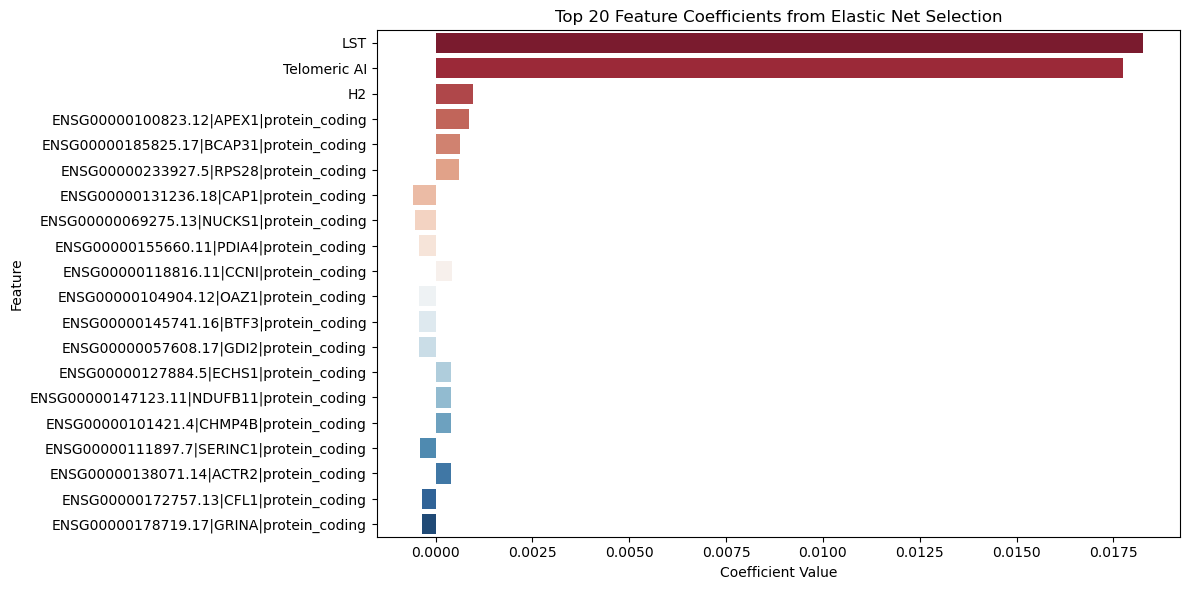


Shape of selected feature matrix: (905, 293)


In [305]:

# Run the analysis
selected_features_df = analyze_lasso_selection(lasso_model, X_cleaned, y)

# Create the selected feature matrix
X_lasso_selected = X_cleaned[selected_features_df['Feature']]

print(f"\nShape of selected feature matrix: {X_lasso_selected.shape}")

In [294]:

elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_cleaned, y)
X_elastic_net_selected = X_cleaned.loc[:, elastic_net_model.coef_ != 0]




/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.991e+00, tolerance: 1.660e-02
  model = cd_fast.enet_coordinate_descent(



=== Lasso Feature Selection Results ===

Total features: 2134
Selected features: 338
Features eliminated: 1796

Model R² Score: 0.8620

Selected Features and Their Coefficients:
                                   Feature   Coefficient
                                       LST  1.931155e-02
                              Telomeric AI  1.929802e-02
   ENSG00000100823.12|APEX1|protein_coding  1.321605e-03
                                        H2  9.399739e-04
    ENSG00000057608.17|GDI2|protein_coding -8.708693e-04
    ENSG00000145741.16|BTF3|protein_coding -8.324764e-04
   ENSG00000138071.14|ACTR2|protein_coding  7.943829e-04
    ENSG00000233927.5|RPS28|protein_coding  7.928864e-04
    ENSG00000104904.12|OAZ1|protein_coding -7.842814e-04
  ENSG00000185825.17|BCAP31|protein_coding  7.195158e-04
 ENSG00000147123.11|NDUFB11|protein_coding  7.084013e-04
   ENSG00000169223.15|LMAN2|protein_coding  6.965821e-04
   ENSG00000155660.11|PDIA4|protein_coding -6.634556e-04
   ENSG00000174748.22|R

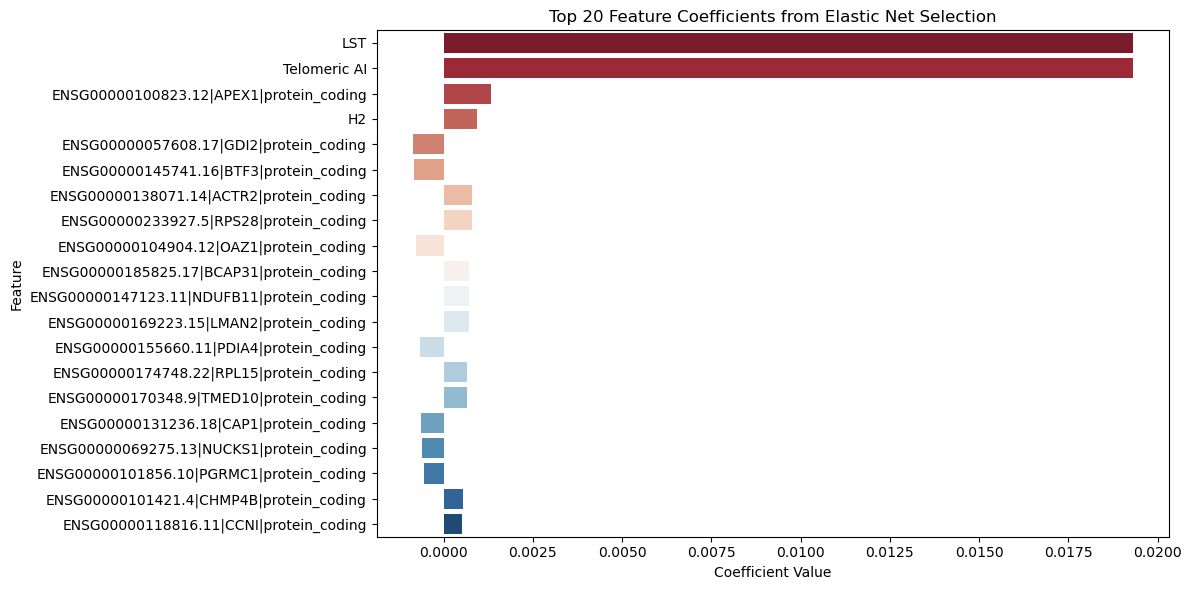


Shape of selected feature matrix: (905, 338)


In [297]:
# Run the analysis
selected_features_df = analyze_lasso_selection(elastic_net_model, X_cleaned, y)

# Create the selected feature matrix
X_elastic_net_selected = X_cleaned[selected_features_df['Feature']]

print(f"\nShape of selected feature matrix: {X_elastic_net_selected.shape}")

In [298]:

# Random Forest Feature Importance
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_cleaned, y)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:10]  # Top 10 features
X_rf_selected = X_cleaned.iloc[:, indices]


In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

def analyze_rf_feature_importance(rf_model, X, y, n_top_features=10, title="Random Forest Feature Importance Analysis"):
    """
    Analyzes and visualizes Random Forest feature importance results
    
    Parameters:
    -----------
    rf_model : fitted RandomForestClassifier
    X : original feature matrix
    y : target variable
    n_top_features : number of top features to select
    title : title for the analysis
    """
    # Get feature importances
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Get top N features
    top_features = feature_importance_df.head(n_top_features)
    
    # Print summary statistics
    print(f"\n=== {title} ===")
    print(f"\nTotal features: {len(X.columns)}")
    print(f"Selected top features: {n_top_features}")
    
    # Model performance metrics
    y_pred = rf_model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"\nModel Performance Metrics:")
    print(f"Accuracy Score: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Print top features with their importance scores
    print(f"\nTop {n_top_features} Features and Their Importance Scores:")
    print(top_features.to_string(index=False))
    
    # Calculate cumulative importance of top features
    cumulative_importance = top_features['Importance'].sum() / feature_importance_df['Importance'].sum()
    print(f"\nCumulative Importance of Top {n_top_features} Features: {cumulative_importance:.2%}")
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Bar plot of feature importance
    sns.barplot(data=top_features, 
                x='Importance', 
                y='Feature',
                palette='viridis',
                ax=ax1)
    ax1.set_title(f'Top {n_top_features} Feature Importance Scores')
    ax1.set_xlabel('Importance Score')
    ax1.set_ylabel('Feature')
    
    # Cumulative importance plot
    cumsum = np.cumsum(feature_importance_df['Importance'])
    n_features = np.arange(1, len(cumsum) + 1)
    ax2.plot(n_features, cumsum, 'b-', label='Cumulative Importance')
    ax2.axvline(x=n_top_features, color='r', linestyle='--', 
                label=f'Top {n_top_features} Features')
    ax2.axhline(y=cumulative_importance, color='r', linestyle='--')
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Cumulative Importance')
    ax2.set_title('Cumulative Feature Importance')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return top_features



=== Random Forest Feature Importance Analysis ===

Total features: 2134
Selected top features: 10

Model Performance Metrics:
Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       686
           1       1.00      1.00      1.00       219

    accuracy                           1.00       905
   macro avg       1.00      1.00      1.00       905
weighted avg       1.00      1.00      1.00       905


Top 10 Features and Their Importance Scores:
                                Feature  Importance
                           Telomeric AI    0.073275
                                    LST    0.068867
                                     H2    0.039315
                                    HRD    0.038561
                                H2.norm    0.014216
 ENSG00000160180.15|TFF3|protein_coding    0.012895
                                H3.norm    0.012170
 ENSG00000065978.19|YBX1|protein_codi

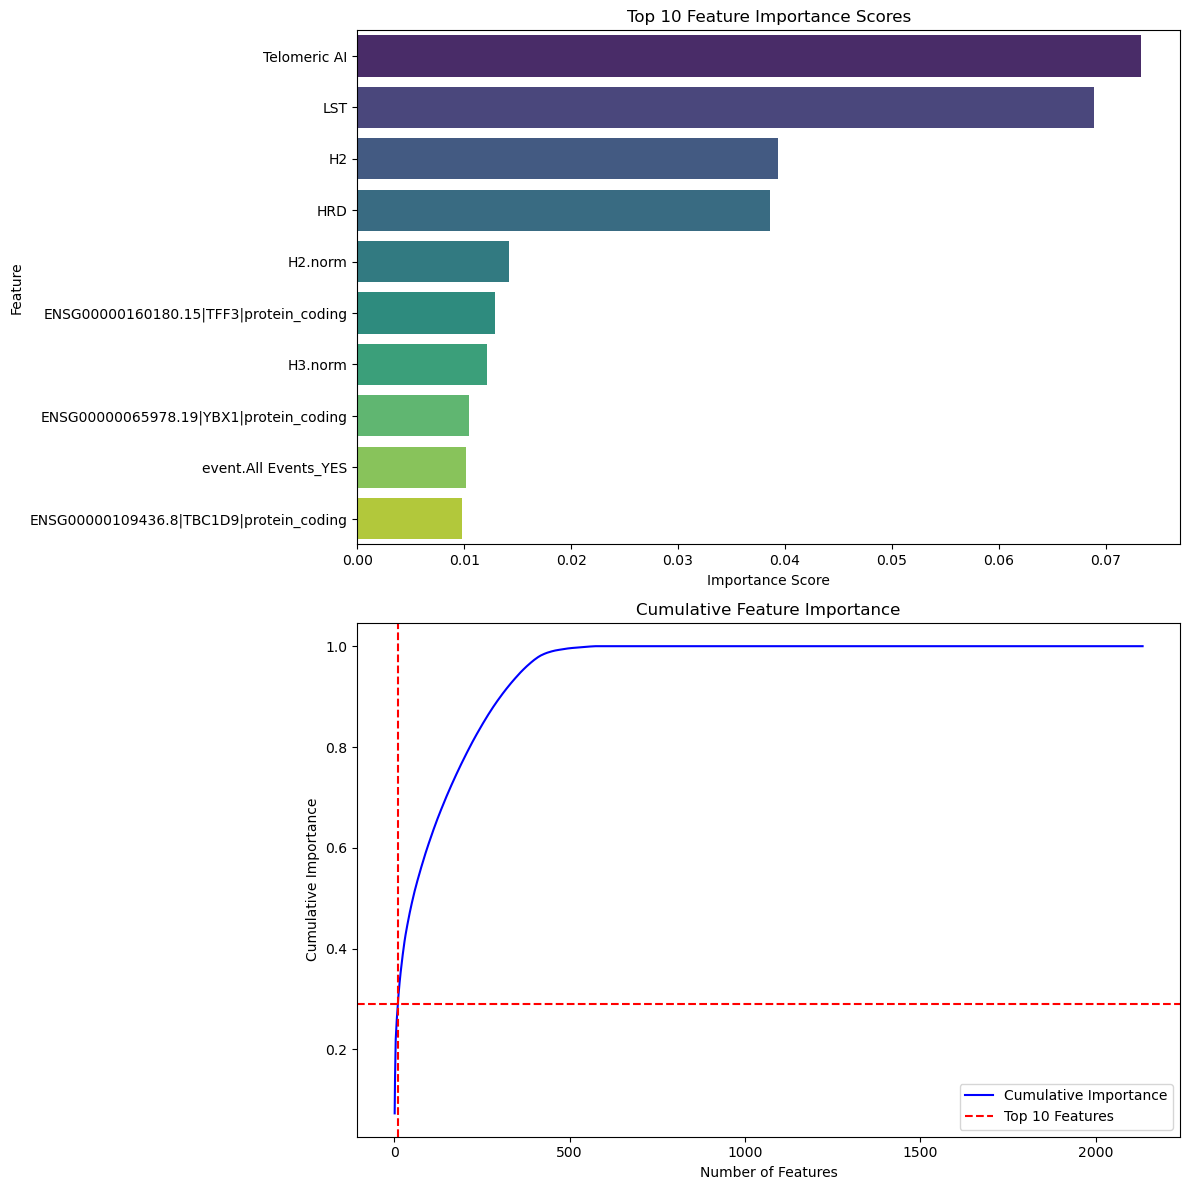


Shape of selected feature matrix: (905, 10)

Cross-validation accuracy scores (5-fold):
Mean CV Accuracy: 0.9072 (+/- 0.2292)


In [301]:

# Run the analysis
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_cleaned, y)
top_features_df = analyze_rf_feature_importance(rf_model, X_cleaned, y, n_top_features=10)

# Create the selected feature matrix
X_rf_selected = X_cleaned[top_features_df['Feature']]

print(f"\nShape of selected feature matrix: {X_rf_selected.shape}")

# Calculate feature importance stability through cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_model, X_rf_selected, y, cv=5)
print(f"\nCross-validation accuracy scores (5-fold):")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

In [299]:
# Univariate Statistical Tests (Chi-Square)
chi2_selector = SelectKBest(chi2, k=10)
X_chi2_selected = chi2_selector.fit_transform(X_cleaned, y)

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import chi2 as chi2_distribution

def analyze_chi2_selection(X, y, k=10, title="Chi-Square Feature Selection Analysis"):
    """
    Analyzes and visualizes Chi-Square feature selection results
    
    Parameters:
    -----------
    X : feature matrix (must be non-negative)
    y : target variable
    k : number of top features to select
    title : title for the analysis
    """
    # Ensure no negative values
    if (X < 0).any().any():
        raise ValueError("Chi-square test requires non-negative values")
    
    # Fit selector
    chi2_selector = SelectKBest(chi2, k=k)
    X_selected = chi2_selector.fit_transform(X, y)
    
    # Get scores and p-values
    scores = chi2_selector.scores_
    p_values = chi2_selector.pvalues_
    
    # Create DataFrame with results
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Chi2_Score': scores,
        'P_Value': p_values
    })
    
    # Sort by chi-square score
    feature_scores = feature_scores.sort_values('Chi2_Score', ascending=False)
    
    # Get selected features
    selected_features = feature_scores.head(k)
    
    # Print summary statistics
    print(f"\n=== {title} ===")
    print(f"\nTotal features: {len(X.columns)}")
    print(f"Selected features: {k}")
    
    # Print selected features with their scores
    print("\nSelected Features, Chi-Square Scores, and P-values:")
    pd.set_option('display.float_format', lambda x: '%.5e' if x < 0.001 else '%.4f' % x)
    print(selected_features.to_string(index=False))
    
    # Count significant features
    alpha = 0.05
    significant_features = feature_scores[feature_scores['P_Value'] < alpha]
    print(f"\nStatistically significant features (p < {alpha}): {len(significant_features)}")
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Bar plot of chi-square scores
    sns.barplot(data=selected_features, 
                x='Chi2_Score', 
                y='Feature',
                palette='YlOrRd',
                ax=ax1)
    ax1.set_title(f'Top {k} Features by Chi-Square Score')
    ax1.set_xlabel('Chi-Square Score')
    ax1.set_ylabel('Feature')
    
    # P-value distribution plot
    sns.histplot(data=feature_scores, x='P_Value', bins=30, ax=ax2)
    ax2.axvline(x=alpha, color='r', linestyle='--', 
                label=f'Significance Level (α={alpha})')
    ax2.set_title('Distribution of P-values')
    ax2.set_xlabel('P-value')
    ax2.set_ylabel('Count')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create correlation matrix for selected features
    X_selected_df = X[selected_features['Feature']]
    correlation_matrix = X_selected_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f')
    plt.title('Correlation Matrix of Selected Features')
    plt.tight_layout()
    plt.show()
    
    return selected_features, X_selected



=== Chi-Square Feature Selection Analysis ===

Total features: 2134
Selected features: 10

Selected Features, Chi-Square Scores, and P-values:
                                 Feature  Chi2_Score  P_Value
  ENSG00000181617.6|FDCSP|protein_coding 257248.7487     %.5e
ENSG00000124935.4|SCGB1D2|protein_coding 136254.3801     %.5e
ENSG00000110484.7|SCGB2A2|protein_coding  96960.6510     %.5e
ENSG00000163220.11|S100A9|protein_coding  92228.6216     %.5e
    ENSG00000159763.4|PIP|protein_coding  72545.4667     %.5e
   ENSG00000160182.3|TFF1|protein_coding  70752.5001     %.5e
  ENSG00000153002.12|CPB1|protein_coding  66713.8836     %.5e
 ENSG00000034510.6|TMSB10|protein_coding  57006.0932     %.5e
ENSG00000143546.10|S100A8|protein_coding  48874.5353     %.5e
   ENSG00000124107.5|SLPI|protein_coding  48584.2337     %.5e

Statistically significant features (p < 0.05): 445


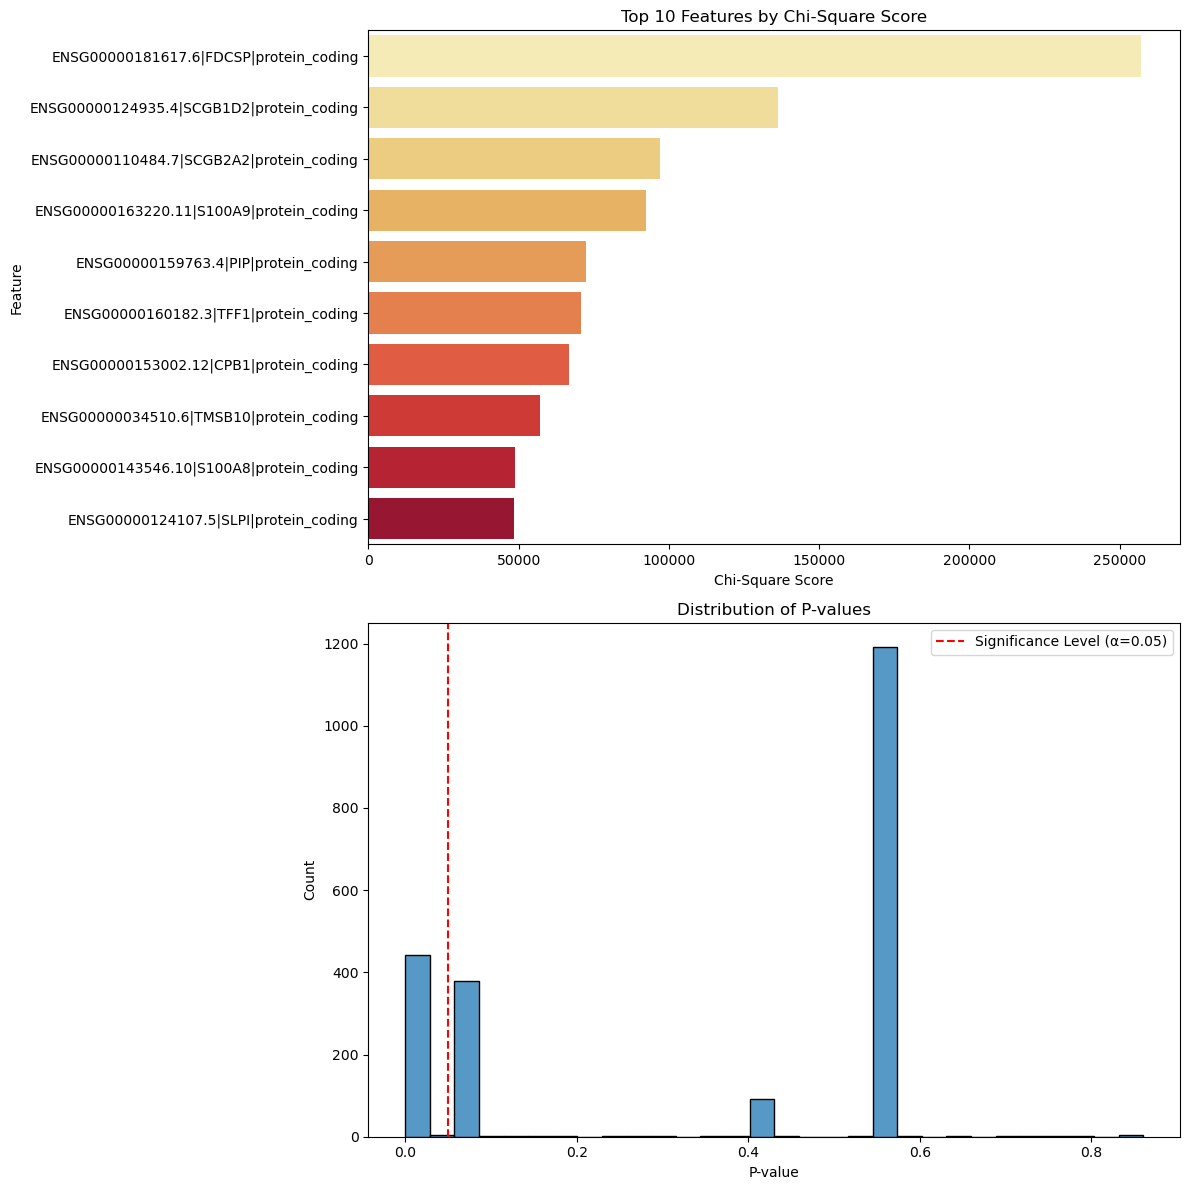

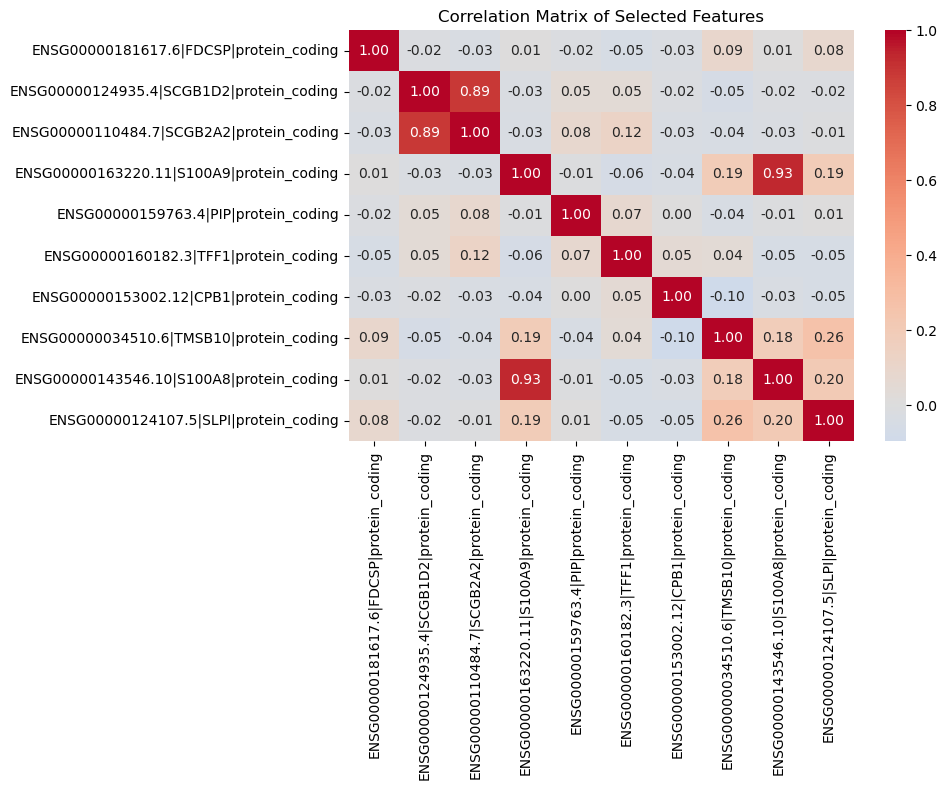


Shape of selected feature matrix: (905, 10)

Performance Comparison (5-fold cross-validation):
Original features - Mean CV Accuracy: 0.8818 (+/- 0.1097)
Selected features - Mean CV Accuracy: 0.7945 (+/- 0.1158)


In [303]:

# Run the analysis
selected_features_df, X_chi2_selected = analyze_chi2_selection(X_cleaned, y, k=10)

print(f"\nShape of selected feature matrix: {X_chi2_selected.shape}")

# Additional analysis: Compare with original feature set
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Create a simple classifier to test feature selection impact
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Compare performance
original_scores = cross_val_score(clf, X_cleaned, y, cv=5)
selected_scores = cross_val_score(clf, X_chi2_selected, y, cv=5)

print("\nPerformance Comparison (5-fold cross-validation):")
print(f"Original features - Mean CV Accuracy: {original_scores.mean():.4f} (+/- {original_scores.std() * 2:.4f})")
print(f"Selected features - Mean CV Accuracy: {selected_scores.mean():.4f} (+/- {selected_scores.std() * 2:.4f})")

In [ ]:


# Step 9: PCA (Dimensionality Reduction)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling data before PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Step 10: Ridge Regression (L2 Regularization)
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)
X_ridge_selected = X.loc[:, ridge_model.coef_ != 0]

# Step 11: Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=10)
X_mi_selected = mi_selector.fit_transform(X, y)

# Step 12: Boruta Algorithm
rf_boruta = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_selector = BorutaPy(rf_boruta, n_estimators='auto', random_state=42)
boruta_selector.fit(X.values, y.values)
X_boruta_selected = X.loc[:, boruta_selector.support_]

# Now, you can evaluate each of the selected feature sets
selected_feature_sets = {
    'Variance Threshold': X_variance_filtered,
    'Chi-Square': X_chi2_selected,
    'RFE': X_rfe_selected,
    'SFS': X_sfs_selected,
    'Lasso': X_lasso_selected,
    'Elastic Net': X_elastic_net_selected,
    'Random Forest': X_rf_selected,
    'PCA': X_pca,
    'Ridge': X_ridge_selected,
    'Mutual Information': X_mi_selected,
    'Boruta': X_boruta_selected
}

# Print selected features for each method
for method, selected_features in selected_feature_sets.items():
    print(f"{method} selected {selected_features.shape[1]} features.")


# DEBUG

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter



def analyze_distribution():
    # Analyze the distribution of HRD and PAM50 subtypes
    print("Distribution of samples across HRD and PAM50:")
    cross_tab = pd.crosstab(final_merged_df['HRD_status'], 
                           final_merged_df['event.PAM50'],
                           margins=True)
    print(cross_tab)
    
    return cross_tab

def balanced_sampling_strategy(X, y, hrd_status, pam50_subtypes):
    """
    Implement stratified sampling to balance both HRD status and PAM50 subtypes
    with proper type handling
    """
    # Convert HRD status and PAM50 subtypes to strings before combining
    hrd_status_str = hrd_status.astype(str)
    pam50_subtypes_str = pam50_subtypes.astype(str)
    
    # Create combined target for stratification
    combined_target = hrd_status_str + "_" + pam50_subtypes_str
    
    # Calculate the minimum number of samples per combination
    value_counts = combined_target.value_counts()
    min_samples = min(value_counts[value_counts > 0])
    
    # Print distribution before sampling
    print("\nDistribution before sampling:")
    print(value_counts)
    
    # Perform stratified undersampling
    rus = RandomUnderSampler(sampling_strategy=lambda y: {
        k: min_samples for k in np.unique(y)
    }, random_state=42)
    
    X_resampled, y_resampled = rus.fit_resample(X, combined_target)
    
    # Split back the combined target
    hrd_resampled = pd.Series([y.split('_')[0] for y in y_resampled])
    pam50_resampled = pd.Series([y.split('_')[1] for y in y_resampled])
    
    # Convert HRD status back to original type if needed
    if hrd_status.dtype != object:
        hrd_resampled = hrd_resampled.astype(hrd_status.dtype)
    
    # One-hot encode the PAM50 subtypes
    onehot = OneHotEncoder(handle_unknown='ignore')
    pam50_onehot = onehot.fit_transform(pam50_resampled.values.reshape(-1, 1))
    
    # Convert to DataFrame with proper column names
    pam50_columns = [f'PAM50_{cat}' for cat in onehot.categories_[0]]
    pam50_onehot_df = pd.DataFrame(pam50_onehot, columns=pam50_columns)
    
    # Print distribution after sampling
    print("\nDistribution after sampling:")
    print(pd.crosstab(hrd_resampled, pam50_resampled))
    
    return X_resampled, hrd_resampled, pam50_onehot_df
def prepare_balanced_data():
    # Extract features and targets
    gene_columns = [col for col in final_merged_df.columns if col.startswith('ENSG')]
    X = final_merged_df[gene_columns]
    hrd_status = final_merged_df['HRD_status']
    pam50_subtypes = final_merged_df['event.PAM50']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=gene_columns)
    
    # Apply balanced sampling and get one-hot encoded PAM50
    X_balanced, hrd_balanced, pam50_onehot = balanced_sampling_strategy(
        X_scaled, hrd_status, hrd_status, pam50_subtypes)
    
    # Combine gene expression data with one-hot encoded PAM50
    X_combined = pd.concat([pd.DataFrame(X_balanced, columns=gene_columns), 
                          pam50_onehot], axis=1)
    
    # Create stratified train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, hrd_balanced,
        stratify=hrd_balanced,  # Stratify by HRD status
        test_size=0.2,
        random_state=42
    )
    
    print("\nFinal shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    print("\nHRD distribution in train set:")
    print(y_train.value_counts())
    print("\nHRD distribution in test set:")
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

def validate_independence():
    """
    Perform chi-square test of independence between HRD status and PAM50
    """
    from scipy.stats import chi2_contingency
    
    contingency_table = pd.crosstab(final_merged_df['HRD_status'],
                                   final_merged_df['event.PAM50'])
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print("Chi-square test of independence:")
    print(f"p-value: {p_value:.10f}")
    return p_value


# Print initial distribution
print("Initial distribution:")
initial_dist = analyze_distribution()

# Prepare balanced dataset
X_train, X_test, y_train, y_test = prepare_balanced_data()

# Analyze final distribution
print("\nFinal training set distribution:")
print(pd.crosstab(y_train, pd.Series(y_test)))

# Validate independence
p_value = validate_independence()
#debug
hrd_status = final_merged_df['HRD_status'].astype(str)
pam50_subtypes = final_merged_df['event.PAM50']
# Create combined target for stratification
combined_target = hrd_status + "_" + pam50_subtypes

# Calculate the minimum number of samples per combination
value_counts = combined_target.value_counts()
min_samples = min(value_counts[value_counts > 0])
print(value_counts)

print(pam50_subtypes.value_counts())
print(min_samples)